In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.pyplot  as plt
import seaborn as sns

train_payment = pd.read_csv('./train_payment.csv')
train_activity = pd.read_csv('./train_activity.csv')
train_combat = pd.read_csv('./train_combat.csv')
train_trade = pd.read_csv('./train_trade.csv')

train_pledge = pd.read_csv('./train_pledge.csv')

train_label = pd.read_csv('./train_label_add.csv')
train_label = train_label.sort_values('acc_id')

In [105]:
# 기본적인 trade df
def trade_40000(train_trade, train_activity):    
    # 주는 유저
    train_trade_source = train_trade[['day', 'time', 'type', 'server', 'source_acc_id', 
                                'source_char_id', 'item_type', 'item_amount','item_price']]
    # 받는 유저
    train_trade_target = train_trade[['day', 'time', 'type', 'server', 'target_acc_id', 
                                'target_char_id', 'item_type', 'item_amount','item_price']]
    # 컬럼명 바꾸기
    train_trade_source = train_trade_source.rename(columns = {'source_acc_id': 'acc_id', 'source_char_id':'char_id',
                                                             'item_amount': 'item_amount_s', 'item_price': 'item_price_s','day':'day_s'})
    train_trade_target = train_trade_target.rename(columns = {'target_acc_id': 'acc_id', 'target_char_id':'char_id',
                                                             'item_amount': 'item_amount_t', 'item_price': 'item_price_t','day':'day_t'})
    
    ## 1. 주는 유저
    # type 분류
    # 교환창이면 1
    train_trade_source['type_ex_s'] = np.where(train_trade_source['type']==0, 1, 0) 
    # 개인상점이면 1
    train_trade_source['type_shop_s'] = np.where(train_trade_source['type']==1, 1, 0) 

    # 나눠진 type 제거
    train_trade_source= train_trade_source.drop('type',axis=1)

    # day 압축
    train_trade_source_allday =  train_trade_source.groupby(['acc_id','char_id']).sum().reset_index()

    # 중복되는 acc id 제거
    train_trade_source_acc = train_trade_source_allday[['acc_id']].drop_duplicates()

    # 진짜 유저만 가려내기 위한 acc 40000명 리스트
    acc = train_activity[['acc_id']].drop_duplicates()

    # 진짜 acc 리스트와 맞지 않는 유저 제거
    train_trade_source_acc_real = pd.merge(acc, train_trade_source_acc, on =['acc_id'], how='inner').sort_values('acc_id')

    # 진짜 target acc_id 와 기존의 데이터 merge(left 조인으로 리스트에 없는 acc id 제거)
    train_trade_source_real = pd.merge(train_trade_source_acc_real, train_trade_source_allday, on =['acc_id'], how='left').sort_values('acc_id')

    # char id 압축
    train_trade_source_sum = train_trade_source_real.groupby('acc_id').sum().reset_index()

    ## 2. 받는 유저
    # type 분류
    train_trade_target['type_ex_t'] = np.where(train_trade_target['type']==0, 1, 0) 
    train_trade_target['type_shop_t'] = np.where(train_trade_target['type']==1, 1, 0) 

    # 나눠진 type 제거
    train_trade_target= train_trade_target.drop('type',axis=1)

    # day 압축
    train_trade_target_allday =  train_trade_target.groupby(['acc_id','char_id']).sum().reset_index()

    # 중복되는 acc id 제거
    train_trade_target_acc = train_trade_target_allday[['acc_id']].drop_duplicates()

    # 진짜 acc 리스트와 맞지 않는 유저 제거
    train_trade_target_acc_real = pd.merge(acc, train_trade_target_acc, on =['acc_id'], how='inner').sort_values('acc_id')

    # 진짜 target acc_id 와 기존의 데이터 merge(left 조인으로 리스트에 없는 acc id 제거)
    train_trade_target_real = pd.merge(train_trade_target_acc_real, train_trade_target_allday, on =['acc_id'], how='left').sort_values('acc_id')
    # char id 압축
    train_trade_target_sum = train_trade_target_real.groupby('acc_id').sum().reset_index()

    # 두 df 합치기 
    source = pd.merge(acc, train_trade_source_sum, on='acc_id', how='left')
    trade = pd.merge(source, train_trade_target_sum, on='acc_id', how='left').fillna(0).sort_values('acc_id')

    # 캐릭터 아이디 컬럼 이름 구분
    trade = trade.drop(['char_id_x', 'char_id_y'], axis=1)
    return trade

In [134]:
trade = trade_40000(train_trade, train_activity)

-------

상관관계 보는 구역

In [19]:
trade[trade['num_trade_both']>0]

,acc_id,day,type_x,item_amount_s,item_price_s,num_trade_s,type_y,item_amount_t,item_price_t,num_trade_t,num_trade_both
987,3290,28,0.0,0.000000e+00,0.000000,0.0,0.0,4.793968e-08,-0.012386,1.0,1.0
1095,3702,28,2.0,1.682578e+00,0.000000,2.0,1.0,1.653928e+00,-0.044677,2.0,4.0
1148,3870,28,0.0,0.000000e+00,0.000000,0.0,9.0,2.446194e-03,0.000000,9.0,9.0
1403,4689,28,3.0,3.247913e-05,0.000000,3.0,0.0,0.000000e+00,0.000000,0.0,3.0
1565,5279,28,3.0,5.033690e-03,0.000000,3.0,3.0,7.191671e-04,0.000000,3.0,6.0
2369,8046,28,0.0,0.000000e+00,0.000000,0.0,0.0,2.396984e-08,-0.003763,1.0,1.0
3157,10515,28,3.0,2.530256e-04,0.000000,3.0,0.0,0.000000e+00,0.000000,0.0,3.0
5898,19440,28,0.0,0.000000e+00,0.000000,0.0,0.0,1.438190e-07,-0.052941,2.0,2.0
6674,21968,28,0.0,2.396984e-08,4.760930,1.0,0.0,2.396984e-07,-0.085506,1.0,2.0
6901,22772,28,0.0,0.000000e+00,0.000000,0.0,1.0,2.396984e-08,0.000000,1.0,1.0


In [104]:
trade_lbl = pd.merge(trade, train_label, on = 'acc_id')
cor = trade_lbl.corr()
cor['total_spent']

acc_id           0.005891
day_s           -0.028126
item_amount_s    0.005079
item_price_s    -0.091549
type_ex_s       -0.065505
type_shop_s      0.054625
day_t            0.121327
item_amount_t    0.020783
item_price_t     0.132432
type_ex_t        0.174003
type_shop_t      0.052796
survival_time    0.279657
amount_spent     0.266910
secession       -0.266477
total_spent      1.000000
Name: total_spent, dtype: float64

In [189]:
# 총결제량 20 초과
over_20 = trade_lbl[trade_lbl['total_spent']>20]
over_10 = trade_lbl[trade_lbl['total_spent']>10]

# 총결제량 20 이하  
under_20 = trade_lbl[(trade_lbl['total_spent']<=20) & (trade_lbl['total_spent']>0)]

# 총결제량 20 미만 10 이상
between_20 = trade_lbl[(trade_lbl['total_spent']<20) & (trade_lbl['total_spent']>=10)]
between_10 = trade_lbl[(trade_lbl['total_spent']<10) & (trade_lbl['total_spent']>0)]

spent_0 = trade_lbl[trade_lbl['total_spent']==0]

In [192]:
between_10.corr()
#['amount_spent'].sort_values(ascending=False)

,acc_id,day_s,item_amount_s,item_price_s,type_ex_s,type_shop_s,day_t,item_amount_t,item_price_t,type_ex_t,...,num_trade,sell_amount,buy_amount,margin,price_diff,amount_diff,survival_time,amount_spent,secession,total_spent
acc_id,1.000000,-0.000542,-0.013874,-0.005961,0.003583,-0.007672,-0.002718,-0.011014,0.006087,0.003654,...,-0.001331,-0.009651,0.000208,-0.002859,-0.008799,-0.014208,-0.008160,0.006354,0.006623,0.012215
day_s,-0.000542,1.000000,0.281606,0.414835,0.890406,0.564521,0.474485,0.278693,0.120898,0.133712,...,0.918816,0.200013,0.169681,-0.111764,0.170173,-0.017758,0.072667,-0.024976,-0.082910,-0.007642
item_amount_s,-0.013874,0.281606,1.000000,0.128010,0.053228,0.550434,0.412705,0.983665,0.216921,0.093580,...,0.398756,0.319607,0.418003,-0.322933,-0.093336,-0.029794,0.043044,-0.010962,-0.050973,0.013911
item_price_s,-0.005961,0.414835,0.128010,1.000000,0.469846,0.100295,0.068158,0.096983,0.074048,0.001704,...,0.344955,0.475766,0.028847,0.102485,0.586740,0.156862,0.076164,-0.023919,-0.088632,-0.027440
type_ex_s,0.003583,0.890406,0.053228,0.469846,1.000000,0.142288,0.112618,0.046211,0.011187,0.012582,...,0.690864,0.174193,-0.001896,0.049766,0.294844,0.032553,0.047303,-0.017984,-0.058306,-0.027140
type_shop_s,-0.007672,0.564521,0.550434,0.100295,0.142288,1.000000,0.839814,0.556327,0.259538,0.280040,...,0.779288,0.146120,0.397023,-0.350022,-0.145868,-0.099051,0.079407,-0.023520,-0.082703,0.035293
day_t,-0.002718,0.474485,0.412705,0.068158,0.112618,0.839814,1.000000,0.434455,0.442761,0.688304,...,0.765584,0.106703,0.431205,-0.394457,-0.315435,-0.170507,0.066672,-0.019601,-0.056629,0.084403
item_amount_t,-0.011014,0.278693,0.983665,0.096983,0.046211,0.556327,0.434455,1.000000,0.291313,0.122665,...,0.405662,0.282594,0.497083,-0.410834,-0.173813,-0.209235,0.040870,-0.009646,-0.047079,0.023584
item_price_t,0.006087,0.120898,0.216921,0.074048,0.011187,0.259538,0.442761,0.291313,1.000000,0.556655,...,0.289739,0.097464,0.757760,-0.717946,-0.764105,-0.439228,0.023164,0.000757,-0.023608,0.076214
type_ex_t,0.003654,0.133712,0.093580,0.001704,0.012582,0.280040,0.688304,0.122665,0.556655,1.000000,...,0.395519,0.013879,0.345730,-0.335977,-0.450905,-0.172777,0.028238,-0.006115,-0.008379,0.117809


-------

# 변수 추가

In [125]:
train_trade.head()

,day,time,type,server,source_acc_id,source_char_id,target_acc_id,target_char_id,item_type,item_amount,item_price
0,7,21:13:05,1,ag,11439,385109,48152,34247,enchant_scroll,4.793968e-08,NaN
1,2,15:33:00,1,al,22220,259705,43228,379826,enchant_scroll,4.314571e-06,NaN
2,1,14:24:53,1,al,18212,164230,38145,34209,accessory,7.190952e-08,NaN
3,7,23:13:43,1,au,121622,49839,71226,281334,adena,9.587936e-03,NaN
4,2,12:43:33,0,bd,14421,344503,65220,210558,etc,1.198492e-07,0.000639


In [124]:
trade.head()

,acc_id,day_s,item_amount_s,item_price_s,type_ex_s,type_shop_s,day_t,item_amount_t,item_price_t,type_ex_t,type_shop_t
22613,2,486.0,0.311620,10.086512,34.0,1.0,9.0,4.793968e-08,0.013612,1.0,0.0
35877,5,0.0,0.000000,0.000000,0.0,0.0,237.0,2.014665e-04,0.432697,10.0,0.0
15227,8,54.0,0.093602,0.000000,0.0,7.0,79.0,2.442839e+00,0.065648,2.0,8.0
17034,17,522.0,4.197842,0.000000,0.0,33.0,990.0,2.972307e+00,7.246862,39.0,18.0
7679,20,126.0,2.205225,14.282791,1.0,8.0,693.0,3.372187e+00,20.513500,36.0,9.0


## 거래 합

In [150]:
# 판매 거래 합, 구매 거래 합
trade['num_trade_s'] = trade['type_ex_s'] + trade['type_shop_s']
trade['num_trade_t'] = trade['type_ex_t'] + trade['type_shop_t']
# 교환창 거래 합
trade['num_trade_ex'] = trade['type_ex_s'] + trade['type_ex_t']

# 개인상점 거래 합
trade['num_trade_shop'] =  trade['type_shop_s'] + trade['type_shop_t']

#총 거래 합
trade['num_trade'] = trade['num_trade_s'] + trade['num_trade_t']

## 구매가격 - 판매 가격

In [159]:
trade['sell_amount'] = trade['item_amount_s'] * trade['item_price_s']
trade['buy_amount'] = trade['item_amount_t'] * trade['item_price_t']
trade['margin'] = trade['sell_amount'] - trade['buy_amount']

In [168]:
trade['price_diff'] =  trade['item_price_s'] - trade['item_price_t']

## 판매 물량 - 구매 물량

In [178]:
trade['amount_diff'] =  trade['item_amount_s'] - trade['item_amount_t']

## 거래 캐릭터가 주캐인지 부캐인지 여부

## 거래일수 / 접속일수

## 하루 평균 거래 일수

## 주 거래 시간대

## 거래 시간 간격

## 거래 아이템 유형 1~6등 or 유형별 %

----------------

In [179]:
trade_lbl = pd.merge(trade, train_label, on = 'acc_id')

In [180]:
plg_data = trade_lbl.drop(['secession','survival_time','amount_spent','total_spent'],axis=1)

In [181]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(plg_data[plg_data.columns[1:]], trade_lbl['total_spent'], test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, X_valid.shape , y_train.shape, y_test.shape, y_valid.shape

((21000, 20), (12000, 20), (7000, 20), (21000,), (12000,), (7000,))

In [182]:
import xgboost as xgb

params =   {
    'learning_rate': 0.02, 
    'gamma' : 0.3, 
    'min_child_weight' : 3,
    'nthread' : 15,
    'max_depth' : 30,
    'subsample' : 0.9,
    'eval_metric' : 'rmse',
    'colsample_bytree' : 0.8, 
    'num_boost_round' : 500,
    'n_estimators': 200,
    'max_leaves': 300,
    'objective': 'reg:linear'
}

In [183]:
VALID = True
if VALID == True:

    tr_data = xgb.DMatrix(X_train, y_train)
    va_data = xgb.DMatrix(X_valid, y_valid)

    

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model_0 = xgb.train(params, tr_data, 500, watchlist, maximize=False, 
                      early_stopping_rounds = 30, verbose_eval=50)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[00:58:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:7.52515	valid-rmse:7.4697
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[50]	train-rmse:4.31584	valid-rmse:6.26977
[100]	train-rmse:2.79813	valid-rmse:6.09927
[150]	train-rmse:2.07349	valid-rmse:6.11134
Stopping. Best iteration:
[123]	train-rmse:2.40287	valid-rmse:6.09651



In [185]:
y_pred = model_0.predict(xgb.DMatrix(X_test))
pred = y_test.reset_index()
pred['pred'] = y_pred

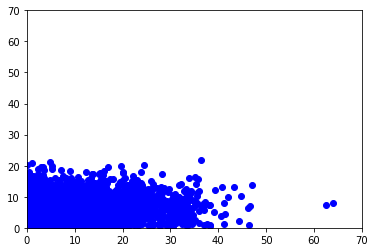

6.227452850591991


In [186]:
# 판매 물량 - 구매 물량
from sklearn.metrics import mean_squared_error as mse

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

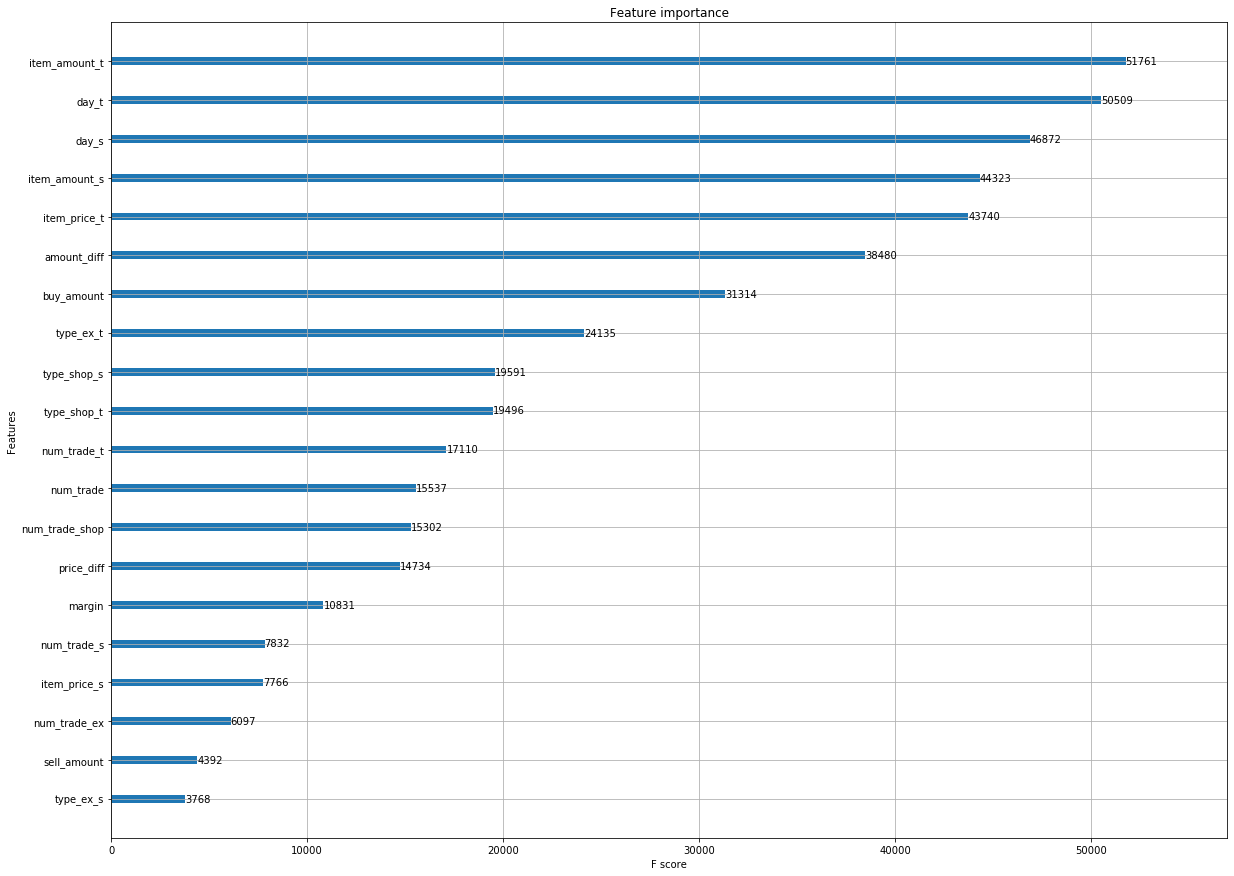

In [187]:
# 판매 물량 - 구매 물량
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
xgb.plot_importance(model_0,ax=ax)
plt.show()

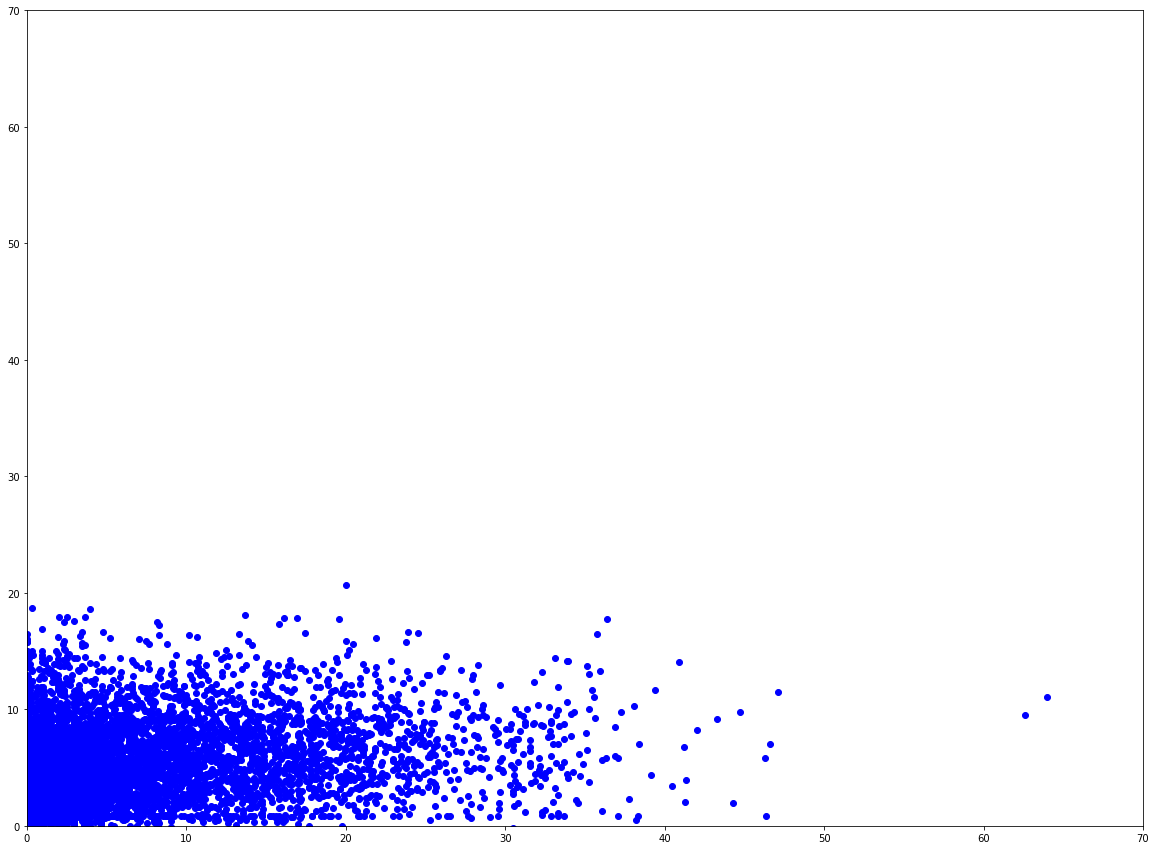

6.206406573994619


In [175]:
# 판매 가격 - 구매 가격
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

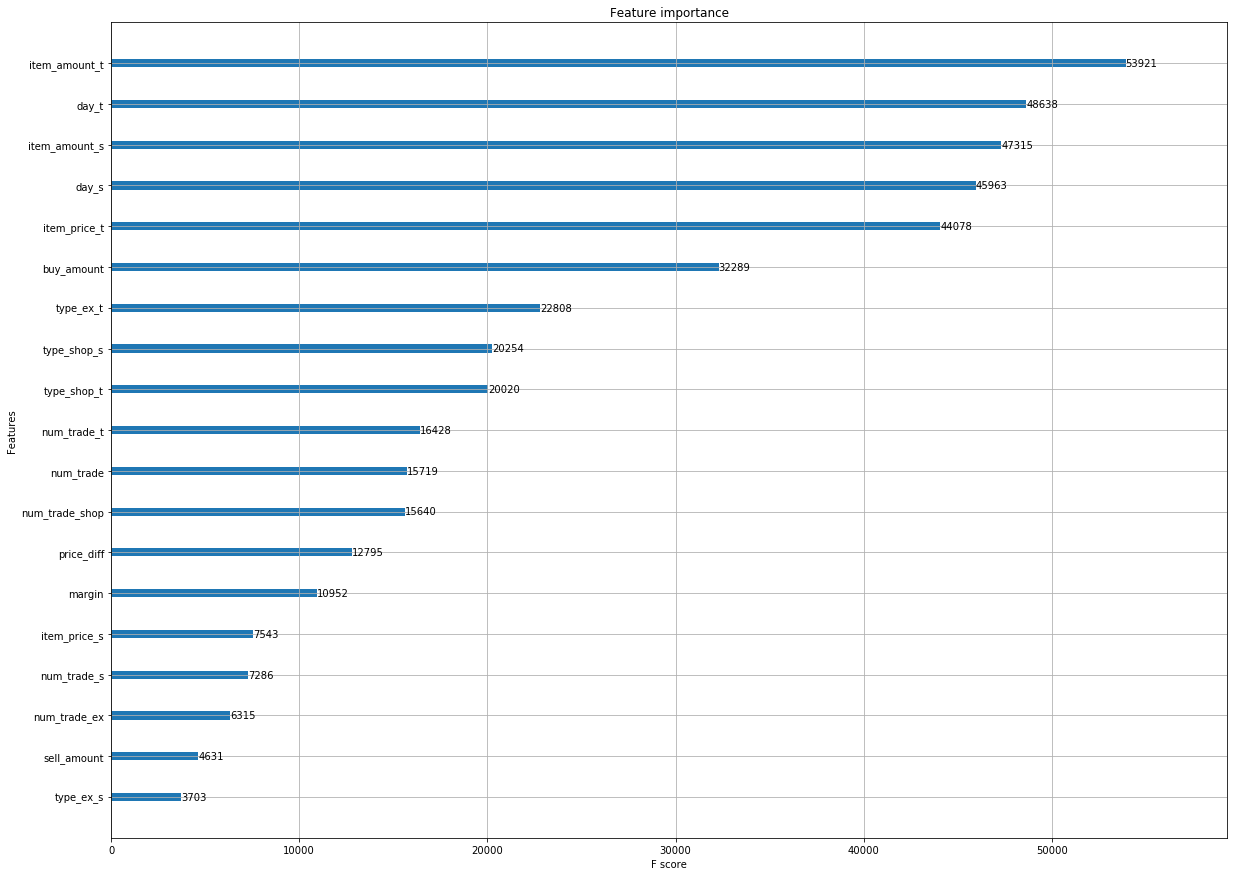

In [177]:
# 판매 가격 - 구매 가격
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
xgb.plot_importance(model_0,ax=ax)
plt.show()

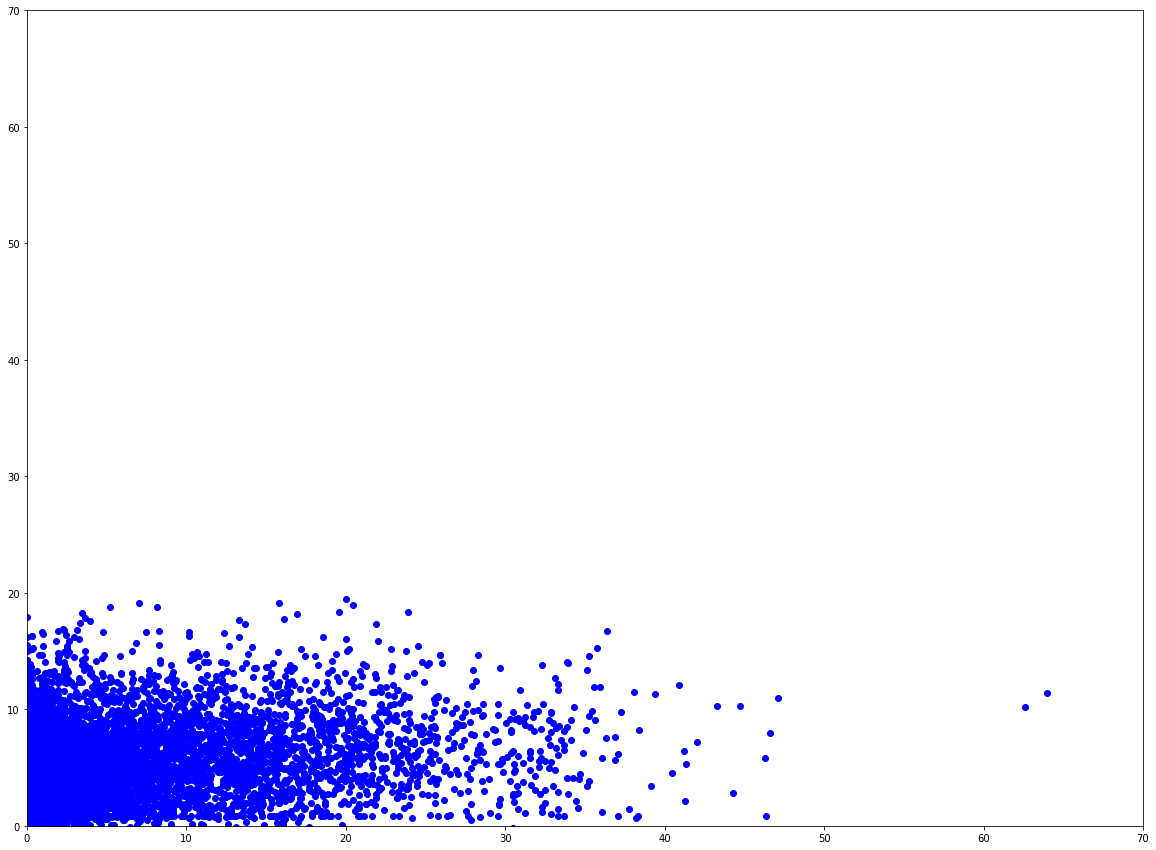

6.188024197723754


In [166]:
# 거래 margin 관련 추가
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

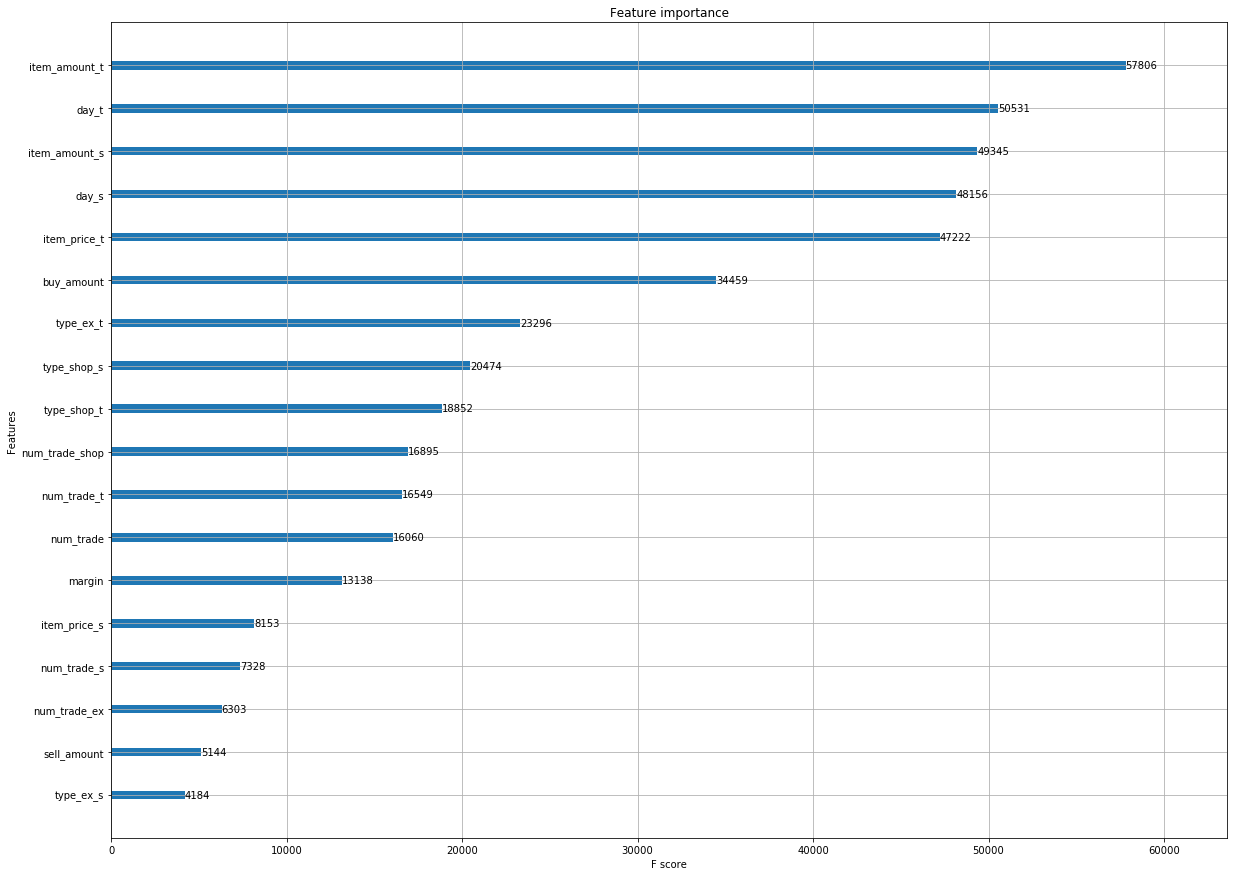

In [167]:
# 거래 margin 관련 추가
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
xgb.plot_importance(model_0,ax=ax)
plt.show()

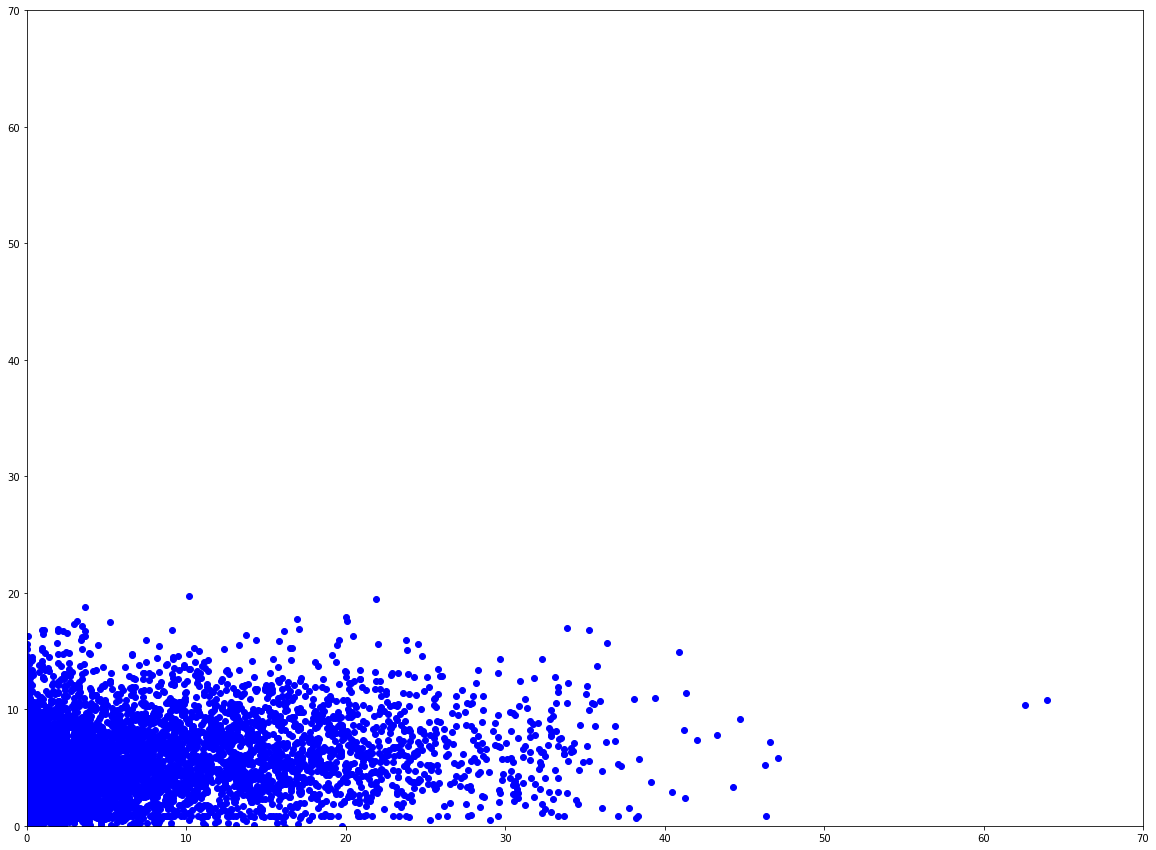

6.185807755435223


In [157]:
# 거래 합 추가
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

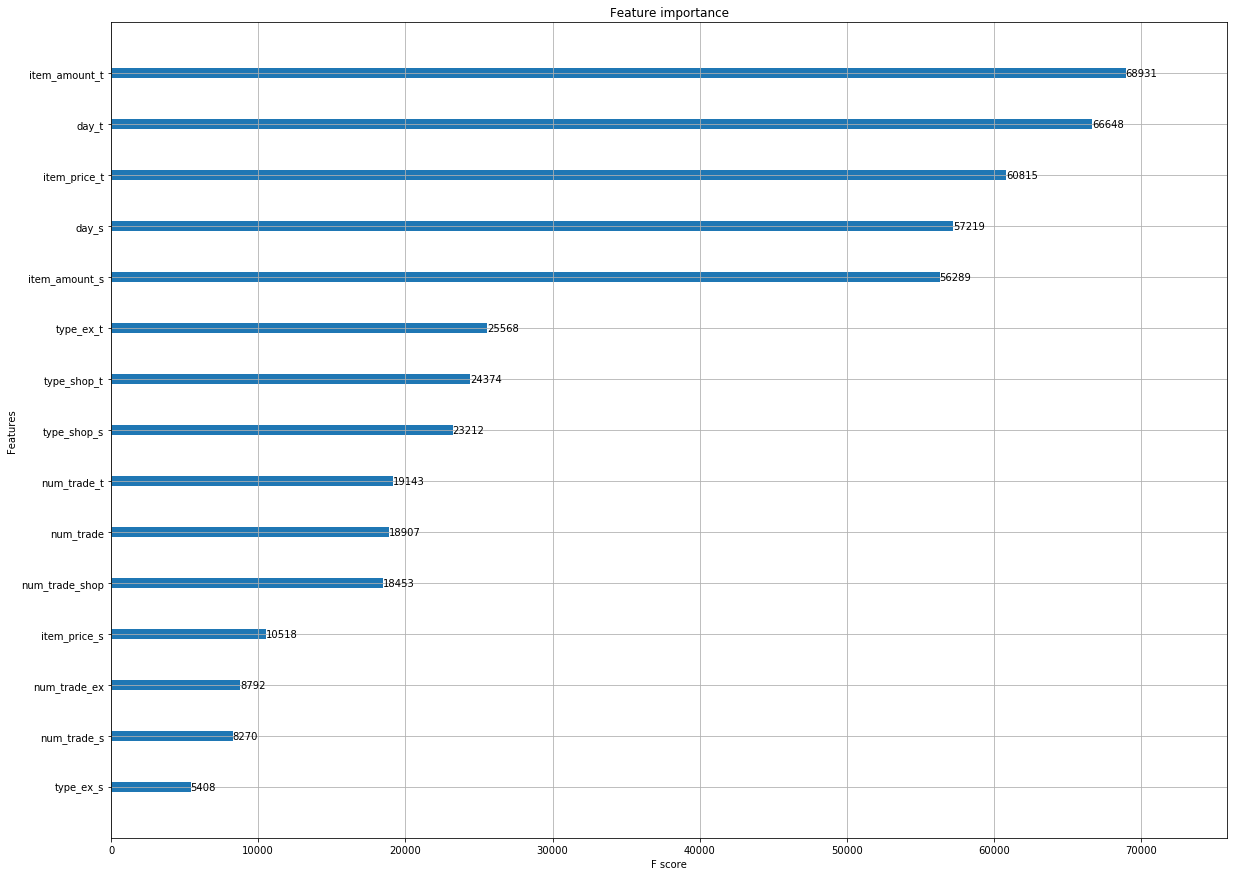

In [158]:
# 거래 합 추가
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
xgb.plot_importance(model_0,ax=ax)
plt.show()

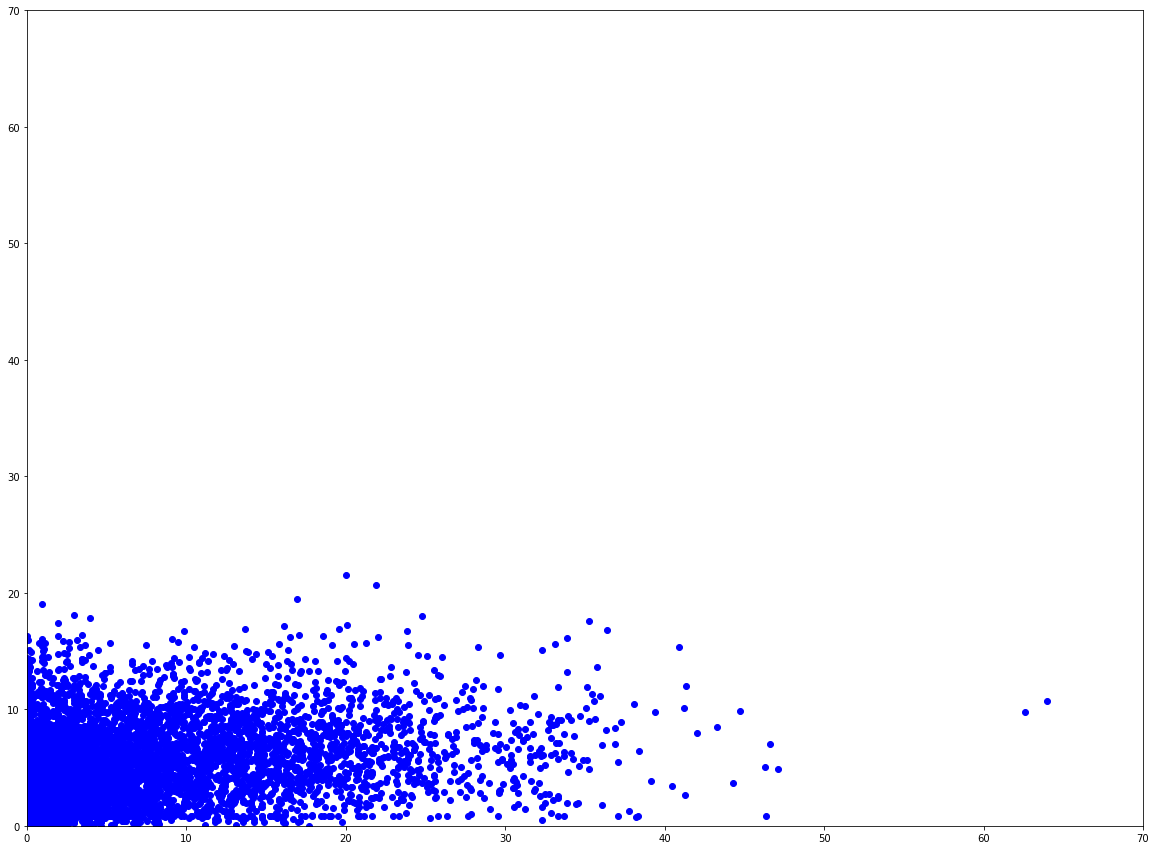

6.18030620539418


In [149]:
# 기본
from sklearn.metrics import mean_squared_error as mse
plt.figure(figsize=(20,15))

plt.plot(pred['total_spent'],pred['pred'],'bo')
plt.axis([0, 70, 0, 70]); plt.show()
linreg_RMSE = np.sqrt(mse(pred['pred'], pred['total_spent']))
print(linreg_RMSE)

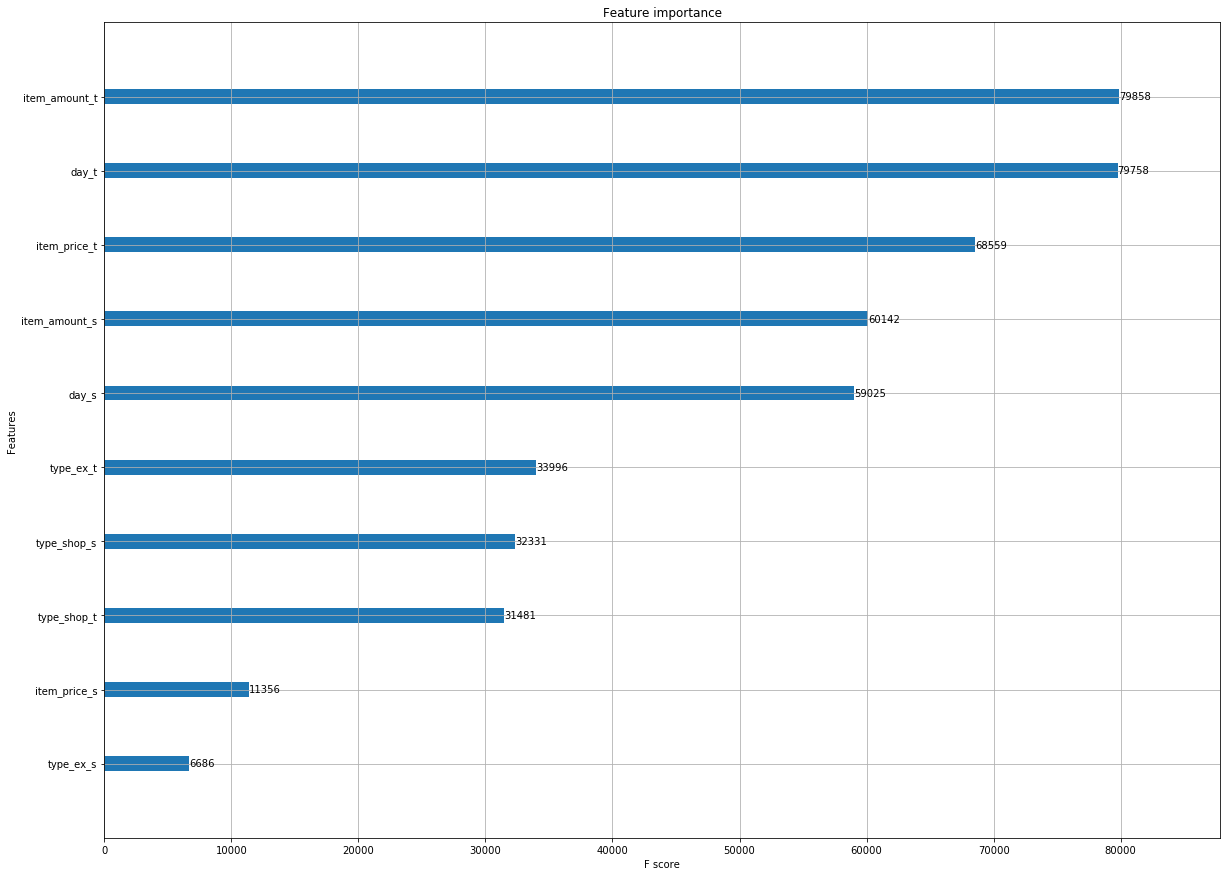

In [141]:
# 기본
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1,1,figsize=(20,15))
xgb.plot_importance(model_0,ax=ax)
plt.show()

----------

## 명훈's 변수

In [60]:
def get_feature_jmh(train_activity, train_trade, train_pledge, train_combat, train_payment):
    train_trade['hour'] = train_trade['time'].map(lambda x : x.split(':')[0])
    train_trade['minute'] = train_trade['time'].map(lambda x : x.split(':')[1])
    train_trade['second'] = train_trade['time'].map(lambda x : x.split(':')[2])

    train_trade = train_trade.sort_values(['day', 'hour', 'minute', 'second'])
    train_trade = train_trade.drop('time', axis=1)
    # combat에서 직업 추출
    class_dict = {0 : '군주', 1 : '기사', 2 : '요정', 3 : '마법사', 4 : '다크엘프', 5 : '용기사', 6 : '환술사', 7 : '전사'}
    acc_char_class = train_combat.groupby(['acc_id', 'char_id'])['class'].mean() # 클래스 변동이 없을 경우
    acc_char_class = acc_char_class.map(lambda x : class_dict[x])

    # activity에서 playtime 추출
    acc_char_playtime = train_activity.groupby(['acc_id', 'char_id'])['playtime'].sum()

    # activity에서 일별 접속 여부 추출
    acc_char_attendant = train_activity.groupby(['acc_id', 'char_id', 'day'])['server'].count().unstack().applymap(lambda x : 1. if x >= 1. else 0).astype(np.uint8)
    acc_char_attendant.columns = ['day' + str(col) for col in acc_char_attendant.columns]


In [62]:
acc_char_playtime = train_activity.groupby(['acc_id','char_id'])['playtime'].sum()

In [63]:
trade_sell_item = train_trade.groupby(['source_acc_id', 'source_char_id', 'item_type'])['server'].count().unstack().fillna(0)
trade_sell_item.index.names = ['acc_id', 'char_id']
trade_sell_item.columns = ['sell_' + col for col in trade_sell_item.columns]
trade_sell_item = trade_sell_item.loc[acc_char_playtime.index]

trade_buy_item = train_trade.groupby(['target_acc_id', 'target_char_id', 'item_type'])['server'].count().unstack().fillna(0)
trade_buy_item.index.names = ['acc_id', 'char_id']
trade_buy_item.columns = ['buy_' + col for col in trade_buy_item.columns]
trade_buy_item = trade_buy_item.loc[acc_char_playtime.index]

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [68]:
trade_sell_item = train_trade.groupby(['source_acc_id', 'source_char_id', 'item_type'])['server'].count().unstack().fillna(0)
trade_sell_item.index.names = ['acc_id', 'char_id']
trade_sell_item.columns = ['sell_' + col for col in trade_sell_item.columns]
trade_sell_item = trade_sell_item.loc[acc_char_playtime.index]

trade_buy_item = train_trade.groupby(['target_acc_id', 'target_char_id', 'item_type'])['server'].count().unstack().fillna(0)
trade_buy_item.index.names = ['acc_id', 'char_id']
trade_buy_item.columns = ['buy_' + col for col in trade_buy_item.columns]
trade_buy_item = trade_buy_item.loc[acc_char_playtime.index]
    
    # stack memory 해제
del acc_char_playtime
    
    # # Trade 거래 내역 추출
acc_id = train_activity.sort_values('acc_id')['acc_id'].unique() # 사용할 40,000개의 train acc_id 추출
    # X : source_acc_id 총 모음, Y : target_acc_id 총 모음
    # A : X 중 acc_id와의 교집합, B : Y 중 acc_id와의 교집합  으로 정의
trade_source_acc_id = train_trade[np.isin(train_trade['source_acc_id'].values, acc_id)] # A 계산
trade_target_acc_id = train_trade[np.isin(train_trade['target_acc_id'].values, acc_id)] # B 계산

    # A 교집합 B 계산
trade_all_acc_id = train_trade[np.logical_and(
        np.isin(train_trade['source_acc_id'].values, acc_id),
        np.isin(train_trade['target_acc_id'].values, acc_id))]

    # A-B를 계산하기 위해 논리식 연산
source_gate = np.logical_and(
        np.isin(train_trade['source_acc_id'].values, acc_id),
        np.logical_xor(
            np.isin(train_trade['source_acc_id'].values, acc_id),
            np.isin(train_trade['target_acc_id'].values, acc_id)
        )
    )
    # B-A를 계산하기 위해 논리식 연산
target_gate = np.logical_and(
        np.isin(train_trade['target_acc_id'].values, acc_id),
        np.logical_xor(
            np.isin(train_trade['target_acc_id'].values, acc_id),
            np.isin(train_trade['source_acc_id'].values, acc_id)
        )
    )

trade_only_source_acc_id = train_trade[source_gate] # A-B 계산
trade_only_target_acc_id = train_trade[target_gate] # B-A 계산

    # 위에서 만든 A|B(A>>B, A<<B), A-B, B-A 4개 X 거래 타입(type=0 or 1) 2개, 총 8개의 변수를 생성
acc_char_source_t0 = trade_only_source_acc_id[trade_only_source_acc_id['type'] == 0].groupby(['source_acc_id', 'source_char_id'])['server'].count()
acc_char_source_t0.index.names = ['acc_id', 'char_id']
acc_char_source_t0.name = 'source2other_t0'

acc_char_source_t1 = trade_only_source_acc_id[trade_only_source_acc_id['type'] == 1].groupby(['source_acc_id', 'source_char_id'])['server'].count()
acc_char_source_t1.index.names = ['acc_id', 'char_id']
acc_char_source_t1.name = 'source2other_t1'

acc_char_target_t0 = trade_only_target_acc_id[trade_only_target_acc_id['type'] == 0].groupby(['target_acc_id', 'target_char_id'])['server'].count()
acc_char_target_t0.index.names = ['acc_id', 'char_id']
acc_char_target_t0.name = 'other2target_t0'

acc_char_target_t1 = trade_only_target_acc_id[trade_only_target_acc_id['type'] == 1].groupby(['target_acc_id', 'target_char_id'])['server'].count()
acc_char_target_t1.index.names = ['acc_id', 'char_id']
acc_char_target_t1.name = 'other2target_t1'

acc_char_source2_t0 = trade_all_acc_id[trade_all_acc_id['type'] == 0].groupby(['source_acc_id', 'source_char_id'])['server'].count()
acc_char_source2_t0.index.names = ['acc_id', 'char_id']
acc_char_source2_t0.name = 'source2label_t0'

acc_char_source2_t1 = trade_all_acc_id[trade_all_acc_id['type'] == 1].groupby(['source_acc_id', 'source_char_id'])['server'].count()
acc_char_source2_t1.index.names = ['acc_id', 'char_id']
acc_char_source2_t1.name = 'source2label_t1'

acc_char_target2_t0 = trade_all_acc_id[trade_all_acc_id['type'] == 0].groupby(['target_acc_id', 'target_char_id'])['server'].count()
acc_char_target2_t0.index.names = ['acc_id', 'char_id']
acc_char_target2_t0.name = 'label2target_t0'

acc_char_target2_t1 = trade_all_acc_id[trade_all_acc_id['type'] == 1].groupby(['target_acc_id', 'target_char_id'])['server'].count()
acc_char_target2_t1.index.names = ['acc_id', 'char_id']
acc_char_target2_t1.name = 'label2target_t1'
    
trade_st_01 = pd.concat((
         acc_char_source_t0,    # trade
         acc_char_source_t1,
         acc_char_target_t0,
         acc_char_target_t1,
         acc_char_source2_t0,
         acc_char_source2_t1,
         acc_char_target2_t0,
         acc_char_target2_t1,
    ), axis=1).fillna(0)

C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\jy3.6\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':
